In [4]:
import requests
import zipfile
import io
import os

URL = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"
RAW_DATA_PATH = "data/raw" 

os.makedirs(RAW_DATA_PATH, exist_ok=True)

print(f"Downloading data from {URL}...")
response = requests.get(URL)

if response.status_code == 200:
    print("Download successful. Extracting...")
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(RAW_DATA_PATH)
    print(f"Data extracted to {RAW_DATA_PATH}")
    
    print("Files found:", os.listdir(RAW_DATA_PATH))
else:
    print("Failed to download data.")

Download successful. Extracting...
Data extracted to data/raw
Files found: ['diabetic_data.csv', 'IDS_mapping.csv']


In [5]:
import pandas as pd
import numpy as np

file_path = "data/raw/diabetic_data.csv"
df = pd.read_csv(file_path, na_values=["?"])

print(f"Dataset Shape: {df.shape}")
print("-" * 30)

# Check the Target Variable (readmitted)
print("Target Variable Distribution:")
print(df['readmitted'].value_counts(normalize=True))
print("-" * 30)

# Check for Missing Values (Top 10 columns)
print("Top 10 Columns with Missing Values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

C:\Users\ABCD\AppData\Local\Temp\ipykernel_7452\171618903.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, na_values=["?"])


Dataset Shape: (101766, 50)
------------------------------
Target Variable Distribution:
readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64
------------------------------
Top 10 Columns with Missing Values:
weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
patient_nbr              0
dtype: int64


In [6]:
# 1. Drop columns with too much missing data or low value
# 'weight': 97% missing
# 'payer_code': 40% missing and not clinically relevant for this model
# 'encounter_id', 'patient_nbr': IDs are not predictors
cols_to_drop = ['weight', 'payer_code', 'encounter_id', 'patient_nbr']
df_clean = df.drop(columns=cols_to_drop)

# 2. Filter out patients who died or were discharged to hospice
# According to the dataset documentation (IDs_mapping.csv):
# 11, 13, 14, 19, 20, 21 = Expired (Died) or Hospice
ids_dead_or_hospice = [11, 13, 14, 19, 20, 21]
df_clean = df_clean[~df_clean['discharge_disposition_id'].isin(ids_dead_or_hospice)]

# 3. Create the Binary Target
# 1 = Readmitted within 30 days (The High Risk group)
# 0 = Readmitted >30 days or Never
df_clean['target'] = (df_clean['readmitted'] == '<30').astype(int)

# Drop the original 'readmitted' column to prevent data leakage
df_clean = df_clean.drop(columns=['readmitted'])

# 4. Handle "Informative" Missingness
# For medical specialty, fill missing with 'Missing' (it's a category)
df_clean['medical_specialty'] = df_clean['medical_specialty'].fillna('Missing')

# For test results, '?' or NaN actually means 'None' (Test not done)
# Note: The dataset might use 'None' string or NaN. Let's standardization.
df_clean['max_glu_serum'] = df_clean['max_glu_serum'].fillna('None')
df_clean['A1Cresult'] = df_clean['A1Cresult'].fillna('None')

# 5. Final Sanity Check
print(f"New Shape: {df_clean.shape}")
print(f"Target Distribution:\n{df_clean['target'].value_counts(normalize=True)}")

New Shape: (99343, 46)
Target Distribution:
target
0    0.886112
1    0.113888
Name: proportion, dtype: float64


In [7]:
# Function to group ICD-9 codes into 9 major categories
def map_diagnosis(code):
    if str(code).startswith('250'): return 'Diabetes'
    
    try:
        n = float(code)
    except:
        return 'Other' # For codes starting with V or E
        
    if 390 <= n <= 459 or n == 785: return 'Circulatory'
    if 460 <= n <= 519 or n == 786: return 'Respiratory'
    if 520 <= n <= 579 or n == 787: return 'Digestive'
    if 800 <= n <= 999: return 'Injury'
    if 710 <= n <= 739: return 'Musculoskeletal'
    if 580 <= n <= 629 or n == 788: return 'Genitourinary'
    if 140 <= n <= 239: return 'Neoplasms'
    
    return 'Other'

# Apply the mapping to all 3 diagnosis columns
print("Grouping diagnosis codes... (This might take a second)")
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_clean[col] = df_clean[col].apply(map_diagnosis)

print("Diagnosis grouping complete.")

# --- Encoding & Splitting ---
from sklearn.model_selection import train_test_split

# 1. Define Features (X) and Target (y)
X = df_clean.drop(columns=['target'])
y = df_clean['target']

# 2. One-Hot Encoding
# This converts "Race: AfricanAmerican" into a column of 1s and 0s
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. Split Data (80% Train, 20% Test)
# Stratify=y ensures we keep that 11% readmission rate in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("-" * 30)
print(f"Training Features Shape: {X_train.shape}")
print(f"Test Features Shape: {X_test.shape}")

Grouping diagnosis codes... (This might take a second)
Diagnosis grouping complete.
------------------------------
Training Features Shape: (79474, 178)
Test Features Shape: (19869, 178)


In [9]:
import re

# 1. Sanitize Column Names
# Replace any character that isn't a letter, number, or underscore with '_'
new_columns = [re.sub(r'[^\w]', '_', col) for col in X_encoded.columns]
X_encoded.columns = new_columns

print("Column names sanitized.")

# 2. Re-Split the Data (to update the column names in X_train/X_test)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Re-Train LightGBM
print("Retraining LightGBM Model...")
model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    scale_pos_weight=scale_weight,
    n_estimators=100,
    learning_rate=0.05,
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train)

# 4. Scorecard
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("-" * 30)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 5. Save the Clean Model
joblib.dump(model, 'models/lgbm_readmission_v1.pkl')
joblib.dump(X_train.columns.tolist(), 'models/feature_names.pkl')
print("Model and cleaned feature names saved.")

Column names sanitized.
Retraining LightGBM Model...
------------------------------
ROC-AUC Score: 0.6739
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77     17606
           1       0.18      0.60      0.28      2263

    accuracy                           0.65     19869
   macro avg       0.55      0.63      0.52     19869
weighted avg       0.84      0.65      0.71     19869

Model and cleaned feature names saved.


SHAP returned a single matrix. Using it directly.
Plotting shape: (2000, 178)


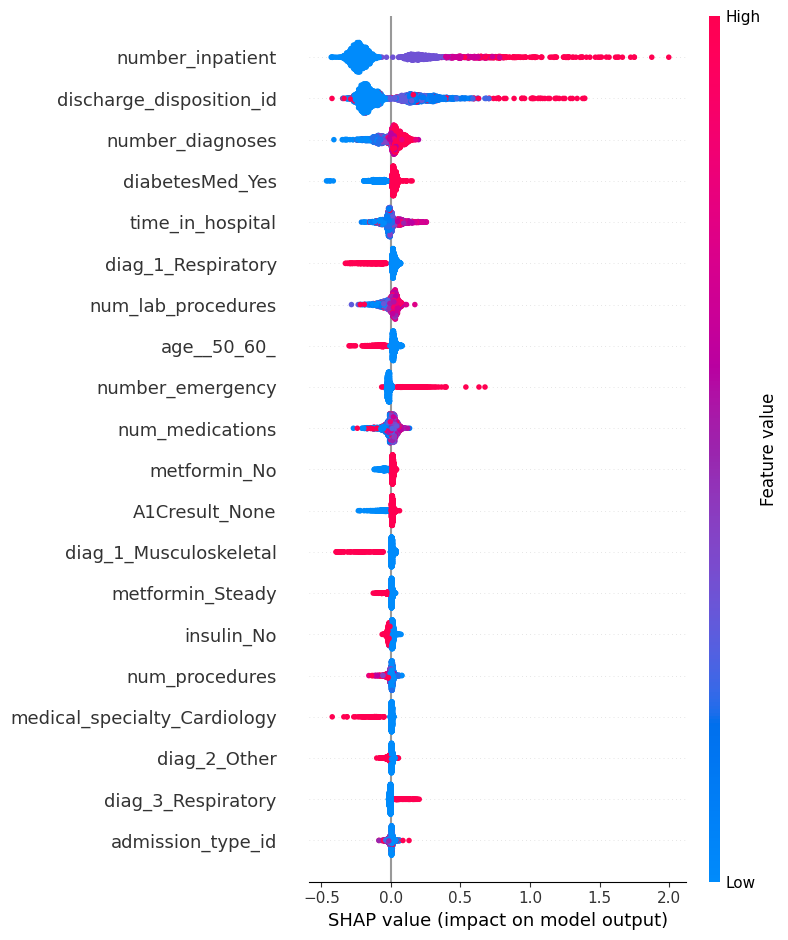

In [11]:
import numpy as np

# 1. Check the type of shap_values
# If it's a list, we want index 1 (Positive Class).
# If it's already an array, we use it as is.
if isinstance(shap_values, list):
    print("SHAP returned a list (Class 0, Class 1). Selecting Class 1.")
    shap_matrix = shap_values[1]
else:
    print("SHAP returned a single matrix. Using it directly.")
    shap_matrix = shap_values

# 2. Verify Shape (Should be (2000, 178))
print(f"Plotting shape: {np.shape(shap_matrix)}")

# 3. Generate Summary Plot
plt.figure()
shap.summary_plot(shap_matrix, sample_X, plot_type="dot")